# Pain in the Net
Replication of *Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images*


Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

---

Source work:
`S. B. Blumberg, R. Tanno, I. Kokkinos, and D. C. Alexander, “Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images,” in Medical Image Computing and Computer Assisted Intervention – MICCAI 2018, Cham, 2018, pp. 118–125, doi: 10.1007/978-3-030-00928-1_14.`


## Imports & Environment Setup

In [1]:
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 1

# imports
import collections
import dataclasses
from dataclasses import dataclass
import functools
import io
import datetime
import time

import math
import itertools
import os
import shutil
import pathlib
import copy
import pdb
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing
from typing import Generator

import ants
import dipy
import dipy.core
import dipy.reconst
import dipy.reconst.dti
import dipy.segment.mask
import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Try importing GPUtil for printing GPU specs.
# May not be installed if using CPU only.
try:
    import GPUtil
except ImportError:
    warnings.warn("WARNING: Package GPUtil not found, cannot print GPU specs")
from tabulate import tabulate

# Data management libraries.
import nibabel as nib
import nilearn
import nilearn.plotting
import natsort
from natsort import natsorted

# Computation & ML libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchio
import pytorch_lightning as pl

import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import scipy
import einops
import einops.layers
import einops.layers.torch

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

In [3]:
# Project-specific scripts
# It's easier to import it this way rather than make an entirely new package, due to
# conflicts with local packages and anaconda installations.
# You made me do this, poor python package management!!
if "PROJECT_ROOT" in os.environ:
    src_location = str(Path(os.environ["PROJECT_ROOT"]).resolve())
else:
    src_location = str(Path("../../").resolve())
sys.path.append(src_location)
import src as pitn

%aimport src

In [4]:
# torch setup

# allow for CUDA usage, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

cuda


In [5]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():

    # GPU information
    # Taken from
    # <https://www.thepythoncode.com/article/get-hardware-system-information-python>.
    # If GPUtil is not installed, skip this step.
    try:
        gpus = GPUtil.getGPUs()
        print("=" * 50, "GPU Specs", "=" * 50)
        list_gpus = []
        for gpu in gpus:
            # get the GPU id
            gpu_id = gpu.id
            # name of GPU
            gpu_name = gpu.name
            driver_version = gpu.driver
            cuda_version = torch.version.cuda
            # get total memory
            gpu_total_memory = f"{gpu.memoryTotal}MB"
            gpu_uuid = gpu.uuid
            list_gpus.append(
                (
                    gpu_id,
                    gpu_name,
                    driver_version,
                    cuda_version,
                    gpu_total_memory,
                    gpu_uuid,
                )
            )

        print(
            tabulate(
                list_gpus,
                headers=(
                    "id",
                    "Name",
                    "Driver Version",
                    "CUDA Version",
                    "Total Memory",
                    "uuid",
                ),
            )
        )
    except NameError:
        print("CUDA Version: ", torch.version.cuda)

else:
    print("CUDA not in use, falling back to CPU")

In [6]:
print(cap)

Author: Tyler Spears

Last updated: 2021-05-06T01:17:15.277515+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-72-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 374081881a505b553d184fbbae91b363c73b9909

nibabel          : 3.2.1
nilearn          : 0.7.1
torch            : 1.8.1
matplotlib       : 3.4.1
einops           : 0.3.0
seaborn          : 0.11.1
pytorch_lightning: 1.2.6
pandas           : 1.2.3
numpy            : 1.20.2
json             : 2.0.9
dipy             : 1.4.0
sys              : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
torchvision      : 0.9.1
natsort          : 7.1.1
ants             : 0.2.7
GPUtil           : 1.4.0
torchio          : 0.18.34
skimage          : 0.18.1

================================================== GPU Specs ==================================================
  id  Name       Dr

## Variables & Definitions Setup

In [7]:
# Set up directories
data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "hcp"
assert data_dir.exists()
write_data_dir = pathlib.Path(os.environ["WRITE_DATA_DIR"]) / "hcp"
assert write_data_dir.exists()
results_dir = pathlib.Path(os.environ["RESULTS_DIR"])
assert results_dir.exists()

In [8]:
# Experiment logging setup
experiment_name = "inst_norm_eps_1e-10_100_epochs_SSE"

ts = datetime.datetime.now().replace(microsecond=0).isoformat()
# Break ISO format because many programs don't like having colons ':' in a filename.
ts = ts.replace(":", "_")
experiment_name = ts + "__" + experiment_name

# Create temporary directory for results directory, in case experiment does not finish.
tmp_results_dir = results_dir / "tmp"
tmp_dirs = list(tmp_results_dir.glob("*"))

# Only keep up to N tmp results.
n_tmp_to_keep = 3
if len(tmp_dirs) > (n_tmp_to_keep - 1):
    print(
        f"More than {n_tmp_to_keep} temporary results, culling to the most recent "
        + f"{n_tmp_to_keep-1}"
    )
    tmps_to_delete = natsorted([str(tmp_dir) for tmp_dir in tmp_dirs])[
        : -(n_tmp_to_keep - 1)
    ]
    for tmp_dir in tmps_to_delete:
        shutil.rmtree(tmp_dir)
        print("Deleted temporary results directory ", tmp_dir)

experiment_results_dir = tmp_results_dir / experiment_name
# Final target directory, to be made when experiment is complete.
final_experiment_results_dir = results_dir / experiment_name

(experiment_results_dir).mkdir(parents=True, exist_ok=True)
print(
    "Experiment results directory: ",
    experiment_results_dir,
)
assert experiment_results_dir.exists()

experiment_results_log = experiment_results_dir / "log.txt"
with open(experiment_results_log, "a+") as f:
    f.write(f"Experiment Name: {experiment_name}\n")
    f.write(f"Timestamp: {ts}\n")
    f.write(f"Environment and Hardware Info:\n {cap}\n\n")

Experiment results directory:  /home/jovyan/work/pitn/results/tmp/2021-05-06T01_17_15__inst_norm_eps_1e-10_100_epochs_SSE


### Global Function & Class Definitions

### Global Parameters

In [9]:
downsample_factor = 2
# Include b=0 shells and b=1000 shells for DTI fitting.
bval_range = (0, 1500)
dti_fit_method = "WLS"

In [10]:
# Patch parameters
batch_size = 64
# 6 channels for the 6 DTI components
channels = 6

# Output patch shapes
h_out = 14
w_out = 14
d_out = 14
# Output shape after shuffling.
output_patch_shape = (channels, h_out, w_out, d_out)
output_spatial_patch_shape = output_patch_shape[1:]
# This is the factor that determines how over-extended the input patch should be
# relative to the size of the full-res patch.
# $low_res_patch_dim = \frac{full_res_patch_dim}{downsample_factor} \times low_res_sample_extension$
# A value of 1 indicates that the input patch dims will be exactly divided by the
# downsample factor. A dilation > 1 increases the "spatial extent" of the input
# patch, providing information outside of the target HR patch.
low_res_sample_extension = 1.57
# Input patch parameters
h_in = round(h_out / (downsample_factor) * low_res_sample_extension)
w_in = round(w_out / (downsample_factor) * low_res_sample_extension)
d_in = round(d_out / (downsample_factor) * low_res_sample_extension)
input_patch_shape = (channels, h_in, w_in, d_in)
input_spatial_patch_shape = input_patch_shape[1:]

# Pre-shuffle output patch sizes.
unshuffled_channels_out = channels * downsample_factor ** 3
# Output before shuffling
unshuffled_output_patch_shape = (unshuffled_channels_out, h_in, w_in, d_in)

In [11]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Downsample Factor: {downsample_factor}\n")
    f.write(f"DTI Fit Method: {dti_fit_method}\n")
    f.write(f"Input Patch Size: {input_patch_shape}\n")
    f.write(f"Output Patch Size: {output_patch_shape}\n")
    f.write(f"Batch Size: {batch_size}\n")

## Data Loading

### Subject ID Selection

In [12]:
# Find data directories for each subject.
subj_dirs: dict = dict()

selected_ids = [
    "397154",
    "224022",
    "140117",
    "751348",
    "894774",
    "156637",
    "227432",
    "303624",
    "185947",
    "810439",
    "753251",
    "644246",
    "141422",
    "135528",
    "103010",
    "700634",
]

## Sub-set the chosen participants for dev and debugging!
selected_ids = random.sample(selected_ids, 10)
warnings.warn(
    "WARNING: Sub-selecting participants for dev and debugging. "
    + f"Subj IDs selected: {selected_ids}"
)
# ### A nested warning! For debugging only.
# warnings.warn("WARNING: Mixing training and testing subjects")
# selected_ids.append(selected_ids[0])
# ###
##

selected_ids = natsorted(list(map(lambda s: int(s), selected_ids)))

for subj_id in selected_ids:
    subj_dirs[subj_id] = data_dir / f"{subj_id}/T1w/Diffusion"
    assert subj_dirs[subj_id].exists()
subj_dirs

<ipython-input-12-a40943793870>:25: UserWarning:




{103010: PosixPath('/mnt/storage/data/pitn/hcp/103010/T1w/Diffusion'),
 140117: PosixPath('/mnt/storage/data/pitn/hcp/140117/T1w/Diffusion'),
 185947: PosixPath('/mnt/storage/data/pitn/hcp/185947/T1w/Diffusion'),
 224022: PosixPath('/mnt/storage/data/pitn/hcp/224022/T1w/Diffusion'),
 227432: PosixPath('/mnt/storage/data/pitn/hcp/227432/T1w/Diffusion'),
 303624: PosixPath('/mnt/storage/data/pitn/hcp/303624/T1w/Diffusion'),
 700634: PosixPath('/mnt/storage/data/pitn/hcp/700634/T1w/Diffusion'),
 751348: PosixPath('/mnt/storage/data/pitn/hcp/751348/T1w/Diffusion'),
 810439: PosixPath('/mnt/storage/data/pitn/hcp/810439/T1w/Diffusion'),
 894774: PosixPath('/mnt/storage/data/pitn/hcp/894774/T1w/Diffusion')}

The 90 scans are taken from the $b=1000 \ s/mm^2$. However, the $b=0$ shells are still required for fitting the diffusion tensors (DTI's), so those will need to be kept, too.

To find those, sub-select with the $0 < bvals < 1500$, or roughly thereabout. A b-val of $995$ or $1005$ still counts as a b=1000.

In [13]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Selected Subjects: {selected_ids}\n")

### Loading and Preprocessing

In [ ]:
# Import all image data into a sequence of `torchio.Subject` objects.
subj_data: dict = dict()

for subj_id, subj_dir in subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals = torch.as_tensor(np.loadtxt(subj_dir / "bvals").astype(int))
    bvecs = torch.as_tensor(np.loadtxt(subj_dir / "bvecs"))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    # grad = torchio.ScalarImage(subj_dir/"grad_dev.nii.gz")
    brain_mask = torchio.LabelMap(
        subj_dir / "nodif_brain_mask.nii.gz",
        type=torchio.LABEL,
        channels_last=False,
    )

    # The brain mask is binary.
    brain_mask.set_data(brain_mask.data.bool())

    dwi = torchio.ScalarImage(
        subj_dir / "data.nii.gz",
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    # Padding amount for the downsampled DWI's. Padded to account for low-res patches
    # that extend beyond the corresponding full-res patch; otherwise, patches will be
    # sampled outside the low-res volume.
    lr_spatial_padding = int(
        max(
            0,
            np.ceil(
                low_res_sample_extension * (h_out // downsample_factor)
                - (h_out // downsample_factor)
            )
            + 1,
        )
    )
    channel_mean = dwi.data.mean(dim=(1, 2, 3))
    #     channel_std
    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)

    preproc_transforms = torchio.Compose(
        [
            torchio.transforms.ToCanonical(include=("dwi", "brain_mask"), copy=False),
            pitn.transforms.BValSelectionTransform(
                bval_range=bval_range,
                bval_key="bvals",
                bvec_key="bvecs",
                include="dwi",
                copy=False,
            ),
            pitn.transforms.MeanDownsampleTransform(
                downsample_factor,
                spatial_padding=lr_spatial_padding,
                include=("dwi", "brain_mask"),
                keep={"dwi": "fr_dwi", "brain_mask": "fr_brain_mask"},
                copy=False,
            ),
            pitn.transforms.RenameImageTransform(
                {"dwi": "lr_dwi", "brain_mask": "lr_brain_mask"}, copy=False
            ),
            pitn.transforms.FitDTITransform(
                "bvals",
                "bvecs",
                "fr_brain_mask",
                fit_method=dti_fit_method,
                include=("fr_dwi"),
                copy=False,
            ),
            pitn.transforms.FitDTITransform(
                "bvals",
                "bvecs",
                "lr_brain_mask",
                fit_method=dti_fit_method,
                include=("lr_dwi"),
                copy=False,
            ),
            pitn.transforms.RenameImageTransform(
                {"fr_dwi": "fr_dti", "lr_dwi": "lr_dti"}, copy=False
            ),
            pitn.transforms.ImageToDictTransform(
                include=("lr_dti", "lr_brain_mask"), copy=False
            ),
        ]
    )
    # Normalize DTI's to have mean 0 and variance 1.
    preproced_subj = preproc_transforms(subject_dict)
    # Store subject-and-channel-wise means and vars in order to reverse the normalization
    # for the final visualization/output.
    fr_mask = preproced_subj.fr_brain_mask.tensor

    preproced_subj["channel_means"] = (
        (preproced_subj.fr_dti.tensor * fr_mask)
        .mean(dim=(1, 2, 3), keepdim=True)
        .cpu()
        .numpy()
    )
    preproced_subj["channel_var"] = (
        (preproced_subj.fr_dti.tensor * fr_mask)
        .var(dim=(1, 2, 3), keepdim=True)
        .cpu()
        .numpy()
    )

    #     preproced_subj["fr_dti"].set_data(
    #         pitn.data.norm.normalize_dti(
    #             preproced_subj["fr_dti"].data,
    #             torch.as_tensor(preproced_subj["channel_means"]),
    #             torch.as_tensor(preproced_subj["channel_var"]),
    #         )
    #     )
    #     preproced_subj["lr_dti"]["data"] = pitn.data.norm.normalize_dti(
    #         preproced_subj["lr_dti"]["data"],
    #         torch.as_tensor(preproced_subj["channel_means"]),
    #         torch.as_tensor(preproced_subj["channel_var"]),
    #     )
    subj_data[subj_id] = preproced_subj


print("===Data Loaded & Transformed===")

Loading NIFTI image: /mnt/storage/data/pitn/hcp/103010/T1w/Diffusion/data.nii.gz


In [ ]:
subj_dataset = torchio.SubjectsDataset(list(subj_data.values()), load_getitem=False)

## Model Training

### Set Up Patch-Based Data Loaders

In [ ]:
# Data train/validation/test split
test_percent = 0.2
# test_percent = 0.5
train_percent = 1 - test_percent
# val_percent = 0.1

num_subjs = len(subj_dataset)
num_test_subjs = int(np.ceil(num_subjs * test_percent))
num_train_subjs = num_subjs - num_test_subjs
subj_list = subj_dataset.dry_iter()
# Randomly shuffle the list of subjects, then choose the first `num_test_subjs` subjects
# for testing.
random.shuffle(subj_list)

# Create partial function to collect list of samples and form a tuple of tensors.
collate_fn = functools.partial(
    pitn.samplers.collate_subj, full_res_key="fr_dti", low_res_key="lr_dti"
)

test_dataset = torchio.SubjectsDataset(subj_list[:num_test_subjs], load_getitem=False)
# Choose the remaining for training/validation.
# If only 1 subject is available, assume this is a debugging run.
if num_subjs == 1 and num_train_subjs == 0:
    print("DEBUG: Only 1 subject with no training subjects, mixing train and test set")
    subj_list = subj_list[:]
    num_train_subjs = num_test_subjs
else:
    subj_list = subj_list[num_test_subjs:]

train_dataset = torchio.SubjectsDataset(subj_list, load_getitem=False)

# Training patch sampler, random across all patches of all volumes.
train_sampler = pitn.samplers.MultiresSampler(
    source_img_key="fr_dti",
    low_res_key="lr_dti",
    downsample_factor_key="downsample_factor",
    label_name="fr_brain_mask",
    source_spatial_patch_size=output_spatial_patch_shape,
    low_res_spatial_patch_size=input_spatial_patch_shape,
    label_probabilities={0: 0, 1: 1},
)

patches_per_subj = 8000
# Hold enough for 2 epochs at a time.
queue_max_length = patches_per_subj * num_train_subjs * 2

# Set up a torchio.Queue to act as a sampler proxy for the torch DataLoader
train_queue = torchio.Queue(
    train_dataset,
    max_length=queue_max_length,
    samples_per_volume=patches_per_subj,
    sampler=train_sampler,
    shuffle_patches=True,
    shuffle_subjects=True,
    num_workers=7,
    #     verbose=True,
)

train_loader = torch.utils.data.DataLoader(
    train_queue,
    batch_size=batch_size,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=0,
)

# Set up testing objects.
# Calculate the patch overlap needed for ~50% of the patch volume overlapping (which is
# not the same as dividing each dimension by 2).
input_vol_half_overlap = int(
    np.floor(np.power(np.prod(input_spatial_patch_shape) / 2, 1 / 3))
)
# torchio requires an even-numbered overlap.
if input_vol_half_overlap % 2 == 1:
    input_vol_half_overlap += 1
input_vol_half_overlap = np.repeat(input_vol_half_overlap, 3)

# Repeat for the output.
output_vol_half_overlap = np.floor(
    np.power(np.prod(output_spatial_patch_shape) / 2, 1 / 3)
).astype(int)
# torchio requires an even-numbered overlap.
if output_vol_half_overlap % 2 == 1:
    output_vol_half_overlap += 1
output_vol_half_overlap = np.repeat(output_vol_half_overlap, 3)

# Test samplers
test_samplers = list()
for subj in test_dataset.dry_iter():
    test_samplers.append(
        pitn.samplers.MultiresGridSampler(
            subject=subj,
            source_img_key="fr_dti",
            low_res_key="lr_dti",
            downsample_factor_key="downsample_factor",
            source_spatial_patch_size=output_spatial_patch_shape,
            low_res_spatial_patch_size=input_spatial_patch_shape,
            patch_overlap=output_vol_half_overlap,
        )
    )

concat_test_dataset = torch.utils.data.ConcatDataset(test_samplers)
test_loader = torch.utils.data.DataLoader(
    concat_test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=6,
)


print("Test subject(s) IDs: ", [s.subj_id for s in test_dataset.dry_iter()])
print("Training subject(s) IDs: ", [s.subj_id for s in train_dataset.dry_iter()])

In [ ]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Training Set Subjects: {[s.subj_id for s in test_dataset.dry_iter()]}\n")
    f.write(f"Test Set Subjects: {[s.subj_id for s in train_dataset.dry_iter()]}\n")

### Model Definition

In [ ]:
# Full pytorch-lightning module for contained training, validation, and testing.
class DIQTSystem(pl.LightningModule):
    def __init__(
        self, channels, downsample_factor, norm_method=None, train_loss_log_file=None
    ):
        super().__init__()

        self._channels = channels
        self._downsample_factor = downsample_factor

        # Parameters
        # Network parameters
        self.net = pitn.nn.models.ThreeConv(
            self._channels, self._downsample_factor, norm_method=norm_method
        )

        ## Training parameters
        self._lr = 10e-3
        self._betas = (0.9, 0.999)
        #         self._loss_fn = torch.nn.MSELoss(reduction="mean")
        self._loss_fn = torch.nn.MSELoss(reduction="sum")
        #         self._loss_fn = torch.nn.L1Loss(reduction="mean")
        #         self._loss_fn = lambda y_hat, y: torch.sqrt(
        #             F.mse_loss(y_hat, y, reduction="mean")
        #         )

        # My own dinky logging object.
        self.plain_log = {"train_loss": list(), "val_loss": list(), "test_loss": list()}
        self.train_loss_log_file = train_loss_log_file
        if self.train_loss_log_file is not None:
            with open(self.train_loss_log_file, "a+") as f:
                f.write("epoch, batch_idx, loss\n")

    @staticmethod
    def normalize_with_layer(norm_layer, y):

        if norm_layer is not None:
            if not norm_layer.track_running_stats:
                y = norm_layer(y)
            else:
                if isinstance(norm_layer, torch.nn.InstanceNorm3d):
                    y = F.instance_norm(
                        y,
                        eps=norm_layer.eps,
                    )
                elif isinstance(norm_layer, torch.nn.BatchNorm3d):
                    y = F.batch_norm(
                        y,
                        eps=norm_layer.eps,
                    )

        return y

    def forward(self, x):
        y = self.net(x)
        return y

    def training_step(self, batch, batch_idx):
        x, y = batch

        # We need both prediction and ground truth to be a standard normal distribution
        # for a fair calculation of the loss.
        y_pred = self.net(x, norm_output=True)
        if self.net.norm is not None:
            y = self.normalize_with_layer(self.net.norm, y)

        loss = self._loss_fn(y_pred, y)

        self.log("train_loss", loss, logger=False)
        self.plain_log["train_loss"].append(float(loss.cpu()))
        return loss

    def training_epoch_end(self, training_step_outputs):
        # Only log each epoch if a log filename was given.
        if self.train_loss_log_file:

            row_iter = itertools.product(
                (self.current_epoch,),
                range(len(training_step_outputs)),
                [str(float(l["loss"].detach().cpu())) for l in training_step_outputs],
            )

            loss_rows = "".join(
                [
                    f"{epoch}, {batch_idx}, {loss}\n"
                    for epoch, batch_idx, loss in row_iter
                ],
            )

            with open(self.train_loss_log_file, "a+") as f:
                f.write(loss_rows)

    #     def validation_step(self, batch, batch_idx):
    #         pass

    def test_step(self, batch, batch_idx):

        x, y = batch

        # We can't normalize the outputs or ground truth because it would change
        # our units out of $mm^2/s$.
        y_pred = self.net(x, norm_output=False)
#         if self.net.norm is not None:
#             y = self.normalize_with_layer(self.net.norm, y)

        test_loss = torch.sqrt(F.mse_loss(y_pred, y, reduction="mean"))
        self.log("test_loss", test_loss)
        self.plain_log["test_loss"].append(float(test_loss.cpu()))

        return test_loss

    def viz_step(self, x):
        """Step for running inference for the purpose of a visualization.

        Mainly deals with normalization."""

        with torch.no_grad():
            if self.net.training:
                was_training = True
            else:
                was_training = False

            self.net.eval()

            y_pred = self.net(x, norm_output=True)

            if isinstance(self.net.norm, torch.nn.InstanceNorm3d):
                target_mean = torch.mean(x, dim=(2, 3, 4), keepdim=True)
                target_var = torch.var(x, dim=(2, 3, 4), keepdim=True)
                eps = self.net.norm.eps

            elif isinstance(self.net.norm, torch.nn.BatchNorm3d):
                target_mean = torch.mean(x, dim=(0, 2, 3, 4), keepdim=True)
                target_var = torch.var(x, dim=(0, 2, 3, 4), keepdim=True)
                eps = self.net.norm.eps
            else:
                target_mean = torch.zeros(1, 1, 1, 1, 1).to(x)
                target_var = torch.ones(1, 1, 1, 1, 1).to(x)
                eps = 1e-10

            y_pred = pitn.data.norm.denormalize_batch(
                y_pred, target_mean, target_var, eps=eps
            )

            if was_training:
                self.net.train()

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.net.parameters(), lr=self._lr, betas=self._betas
        )
        return optimizer

### Training

In [ ]:
# Training parameters
max_epochs = 100
norm_method = "instance"

In [ ]:
train_loss_name = "Sum SE"
train_loss_log_file = experiment_results_dir / "train_loss.csv"

In [ ]:
train_start_timestamp = datetime.datetime.now().replace(microsecond=0)

model = DIQTSystem(
    channels=channels,
    downsample_factor=downsample_factor,
    train_loss_log_file=train_loss_log_file,
    norm_method=norm_method,
)

with open(experiment_results_log, "a+") as f:
    f.write(f"Max epochs: {max_epochs}\n")
    f.write(f"Model overview: {model}\n")
    f.write(f"Training loss function: {train_loss_name}\n")

# Create trainer object. Note: `automatic_optimization` needs to be set to `False` when
# manually performing backprop. See
# <https://colab.research.google.com/drive/1nGtvBFirIvtNQdppe2xBes6aJnZMjvl8?usp=sharing>
trainer = pl.Trainer(gpus=1, max_epochs=max_epochs, progress_bar_refresh_rate=100)

trainer.fit(model, train_loader)
train_duration = datetime.datetime.now().replace(microsecond=0) - train_start_timestamp

In [ ]:
with open(experiment_results_log, "a+") as f:
    f.write("\n")
    f.write(f"Training time: {train_duration}\n")
    f.write(
        f"\t{train_duration.days} Days, "
        + f"{train_duration.seconds // 3600} Hours,"
        + f"{(train_duration.seconds // 60) % 60} Minutes,"
        + f'{train_duration.seconds % 60} Seconds"\n'
    )

In [ ]:
# Plot rolling average window of training loss values.
plt.figure(dpi=110)
window = 1000
rolling_mean = (
    np.convolve(model.plain_log["train_loss"], np.ones(window), "valid") / window
)
rolling_start = 100
plt.plot(
    np.arange(
        window + rolling_start,
        window + rolling_start + len(rolling_mean[rolling_start:]),
    ),
    rolling_mean[rolling_start:],
)
plt.title("Training Loss " + train_loss_name + f"\nRolling Mean {window}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1)
print(np.median(rolling_mean))
print(
    np.mean(model.plain_log["train_loss"][: window + rolling_start]),
    np.var(model.plain_log["train_loss"][: window + rolling_start]),
    np.max(model.plain_log["train_loss"][: window + rolling_start]),
)

plt.savefig(experiment_results_dir / "train_loss.png")

In [ ]:
len(model.plain_log["train_loss"])

## Model Evaluation

### Testing

In [ ]:
trainer.test(test_dataloaders=test_loader)

In [ ]:
test_loss_name = "RMSE"
test_loss_log_file = experiment_results_dir / "test_loss.csv"

with open(experiment_results_log, "a+") as f:
    f.write(f"Test loss function: {test_loss_name}\n")

row_iter = enumerate(model.plain_log["test_loss"])
test_loss_tabular = "".join([f"{batch_idx}, {loss}\n" for batch_idx, loss in row_iter])

with open(test_loss_log_file, "a+") as f:
    f.write("batch_idx, loss\n")
    f.write(test_loss_tabular)

#### Cubic Spline Baseline

In [83]:
for subj in test_dataset.dry_iter():
    print(subj)

Subject(Keys: ('subj_id', 'fr_brain_mask', 'fr_dti', 'lr_dti', 'lr_brain_mask', 'channel_means', 'channel_var'); images: 2)
Subject(Keys: ('subj_id', 'fr_brain_mask', 'fr_dti', 'lr_dti', 'lr_brain_mask', 'channel_means', 'channel_var'); images: 2)


#### Visualization

In [ ]:
fig, ax_prob = plt.subplots(figsize=(8, 4), dpi=120)

sns.histplot(
    np.asarray(model.plain_log["test_loss"]),
    kde=True,
    stat="probability",
    #     log_scale=True,
    ax=ax_prob,
    label="Current Model",
    legend=False,
)
plt.xlabel("Loss in $mm^2/second$")

# Draw an entire other plot, invisibly, to have another y-axis.
ax_count = ax_prob.twinx()
sns.histplot(
    np.asarray(model.plain_log["test_loss"]), alpha=0, ax=ax_count, stat="count"
)

comparison_kwargs = {"ls": "--", "alpha": 0.8, "lw": 2.5}

plt.axvline(
    np.asarray(model.plain_log["test_loss"]).mean(),
    label="Current Model Mean",
    color="blue",
    **comparison_kwargs,
)
plt.axvline(
    31.738 * 10e-4,
    label="(Tanno etal, 2021) C-spline Mean",
    color="red",
    **comparison_kwargs,
)
plt.axvline(
    23.139 * 10e-4,
    label="(Tanno etal, 2021) RF",
    color="orange",
    **comparison_kwargs,
)
plt.axvline(
    13.609 * 10e-4,
    label="(Tanno etal, 2021) ESPCN Baseline",
    color="green",
    **comparison_kwargs,
)
plt.axvline(
    13.412 * 10e-4,
    label="(Tanno etal, 2021) Best",
    color="purple",
    **comparison_kwargs,
)
plt.axvline(
    12.78 * 10e-4, label="(Blumberg etal, 2018) Best", color="pink", **comparison_kwargs
)

plt.legend(fontsize="small")
plt.title(f"Test Loss Histogram with Test Metric {test_loss_name}")
plt.savefig(experiment_results_dir / "test_loss_hist.png")

In [ ]:
print(np.asarray(model.plain_log["test_loss"]).max())
print(np.asarray(model.plain_log["test_loss"]).mean())

### Visualization

In [61]:
# Create full 3D volume of full-res ground truth, low-res downsample, and high-res
# inferences.
@dataclass
class SubjResult:
    subj_id: int
    full_res: torch.Tensor
    low_res: torch.Tensor
    full_res_predicted: torch.Tensor
    full_res_cubic_spline: np.ndarray


test_vol_results = list()

with torch.no_grad():

    for subj in test_dataset.dry_iter():

        # Create a grid sampler for this subject.
        subj_sampler = pitn.samplers.MultiresGridSampler(
            subject=subj,
            source_img_key="fr_dti",
            low_res_key="lr_dti",
            downsample_factor_key="downsample_factor",
            source_spatial_patch_size=output_spatial_patch_shape,
            low_res_spatial_patch_size=input_spatial_patch_shape,
            #             patch_overlap=output_vol_half_overlap,
            patch_overlap=0,
        )

        loader = torch.utils.data.DataLoader(
            subj_sampler, batch_size=256, pin_memory=True
        )
        aggregator = torchio.GridAggregator(subj_sampler)

        # Iterate over all batches of patches.
        for batch in loader:

            x = batch["lr_dti"]["data"]
            # Locations are in reference to the full-res groud truth.
            locations = batch["location"]
            predictions = model.viz_step(x.to(model.device)).detach().cpu()

            aggregator.add_batch(predictions, locations)

        # Collect all variants of the volume and aggregate into one container object.

        # Calculate cubic spline as a baseline.
        cubic_splines = scipy.ndimage.zoom(
            subj["lr_dti"]["data"].cpu().numpy(),
            zoom=((1,) + (downsample_factor,) * 3),
            order=3,
        )

        subj_means = torch.as_tensor(subj["channel_means"])
        subj_vars = torch.as_tensor(subj["channel_var"])
        subj_result = SubjResult(
            subj_id=subj["subj_id"],
            full_res=subj["fr_dti"].tensor,
            low_res=subj["lr_dti"]["data"],
            full_res_predicted=aggregator.get_output_tensor(),
            full_res_cubic_spline=torch.from_numpy(cubic_splines),
        )

        test_vol_results.append(subj_result)

In [86]:
locations

tensor([[131, 126,  98, 145, 140, 112],
        [131, 126, 112, 145, 140, 126],
        [131, 126, 126, 145, 140, 140],
        ...,
        [131, 160, 112, 145, 174, 126],
        [131, 160, 126, 145, 174, 140],
        [131, 160, 131, 145, 174, 145]])

In [55]:
vis_subj_idx = 1

In [64]:
# Generate FA-weighted diffusion direction map for prediction.
tensor_key = "full_res_predicted"
pred_dir_map = pitn.viz.direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
pred_dir_map = pred_dir_map.transpose(1, 2, 3, 0)

In [65]:
# Generate FA-weighted diffusion direction map for cubic spline interpolation.
tensor_key = "full_res_cubic_spline"
cspline_dir_map = pitn.viz.direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
cspline_dir_map = cspline_dir_map.transpose(1, 2, 3, 0)

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/dipy/reconst/dti.py:84: RuntimeWarning:

invalid value encountered in true_divide



In [66]:
# Generate FA-weighted diffusion direction map.
tensor_key = "full_res"
fr_dir_map = pitn.viz.direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
fr_dir_map = fr_dir_map.transpose(1, 2, 3, 0)

In [67]:
# Generate FA-weighted diffusion direction map for low-res input.
tensor_key = "low_res"
lr_dir_map = pitn.viz.direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
lr_dir_map = lr_dir_map.transpose(1, 2, 3, 0)

In [68]:
slice_idx = (slice(None, None, None), 78, slice(None, None, None))
low_res_slice_idx = tuple(s // 2 if isinstance(s, int) else s for s in slice_idx)
print(slice_idx)
print(low_res_slice_idx)

(slice(None, None, None), 78, slice(None, None, None))
(slice(None, None, None), 39, slice(None, None, None))


In [74]:
cspline_dir_map.shape
fr_dir_map.shape

(145, 174, 145, 3)

(-0.5, 144.5, 144.5, -0.5)

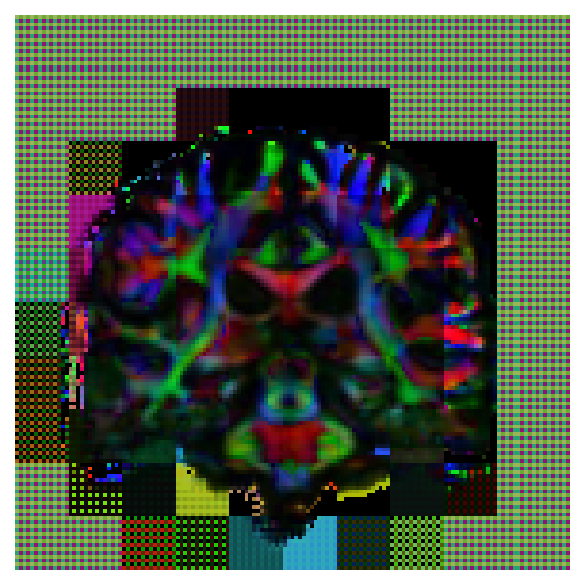

In [69]:
plt.figure(dpi=150)
plt.imshow(np.rot90(pred_dir_map[slice_idx]))
plt.axis("off")
# plt.savefig(experiment_results_dir / "pred_dir_map_sample.png");

(-0.5, 155.5, 155.5, -0.5)

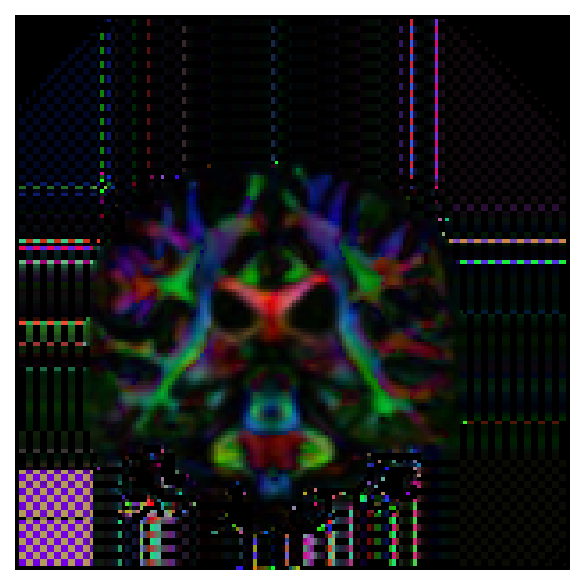

In [70]:
plt.figure(dpi=150)
plt.imshow(np.rot90(cspline_dir_map[slice_idx]))
plt.axis("off")
# plt.savefig(experiment_results_dir / "pred_dir_map_sample.png");

(-0.5, 144.5, 144.5, -0.5)

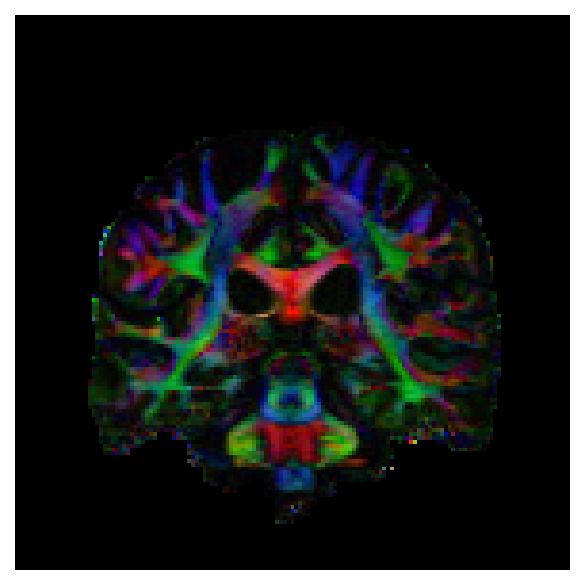

In [71]:
plt.figure(dpi=150)
plt.imshow(np.rot90(fr_dir_map[slice_idx]))
# plt.colorbar()
plt.axis("off")
# plt.savefig(experiment_results_dir / "ground_truth_dir_map_sample.png")

(-0.5, 77.5, 77.5, -0.5)

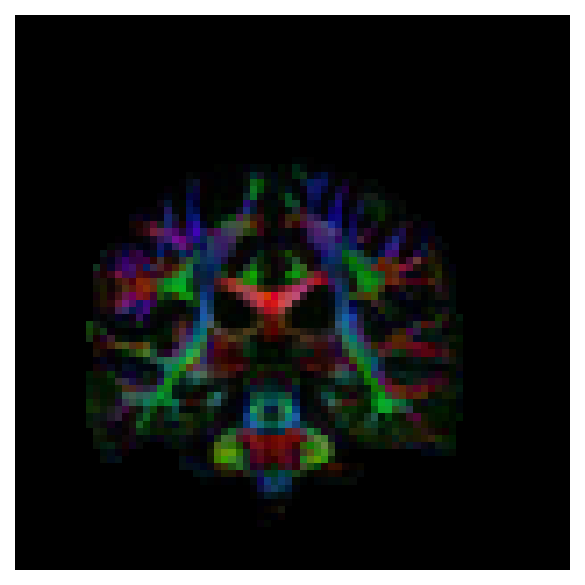

In [75]:
plt.figure(dpi=150)
plt.imshow(np.rot90(lr_dir_map[low_res_slice_idx]))
plt.axis("off")
# plt.savefig(experiment_results_dir / "pred_dir_map_sample.png");

Text(0.5, 0.895, 'DTI Channel Breakdown, Per-Image Normalization')

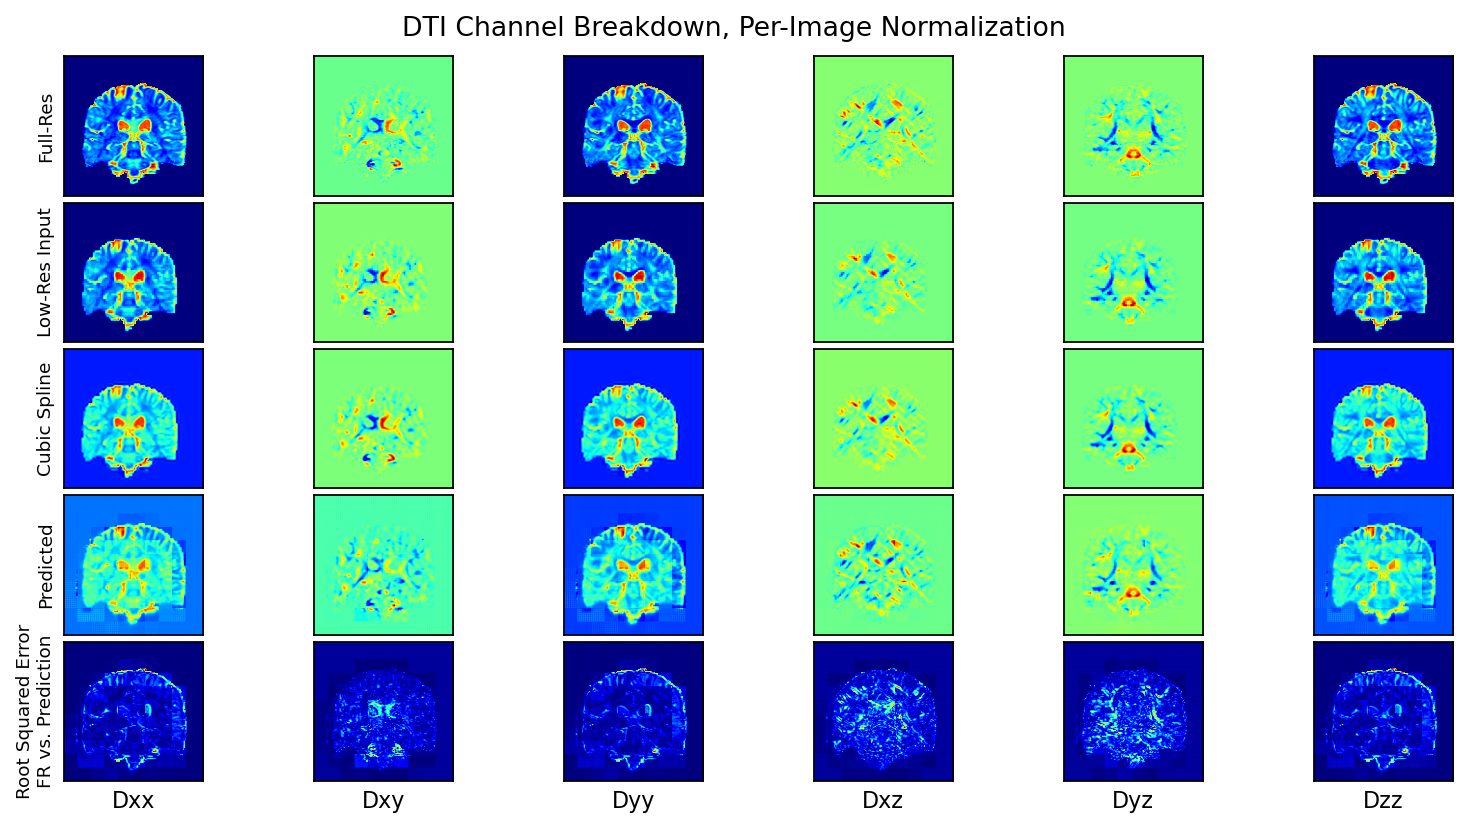

In [77]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

channel_names = ["Dxx", "Dxy", "Dyy", "Dxz", "Dyz", "Dzz"]
dti_names = [
    "Full-Res",
    "Low-Res Input",
    "Cubic Spline",
    "Predicted",
    "Root Squared Error\nFR vs. Prediction",
]
cmap = "jet"
# cmaps = ["Reds", "Greys", "Greens", "Purples", "Greys", "Blues", ]

dtis = [
    test_vol_results[vis_subj_idx]
    .full_res.data[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx]
    .low_res[(slice(None), *low_res_slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx].full_res_cubic_spline[(slice(None), *slice_idx)],
    test_vol_results[vis_subj_idx]
    .full_res_predicted[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
]

# Add root squared error between FR and prediction.
dtis.append(np.sqrt((dtis[0] - dtis[-1]) ** 2))

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(np.rot90(dti[j_col]), cmap=cmap, interpolation=None)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])

        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
plt.suptitle(
    "DTI Channel Breakdown, Per-Image Normalization",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
# plt.savefig(experiment_results_dir / "DTI_channel_sample_per_img_norm.png");

Text(0.5, 0.895, 'DTI Channel Breakdown, Normalized over All Images')

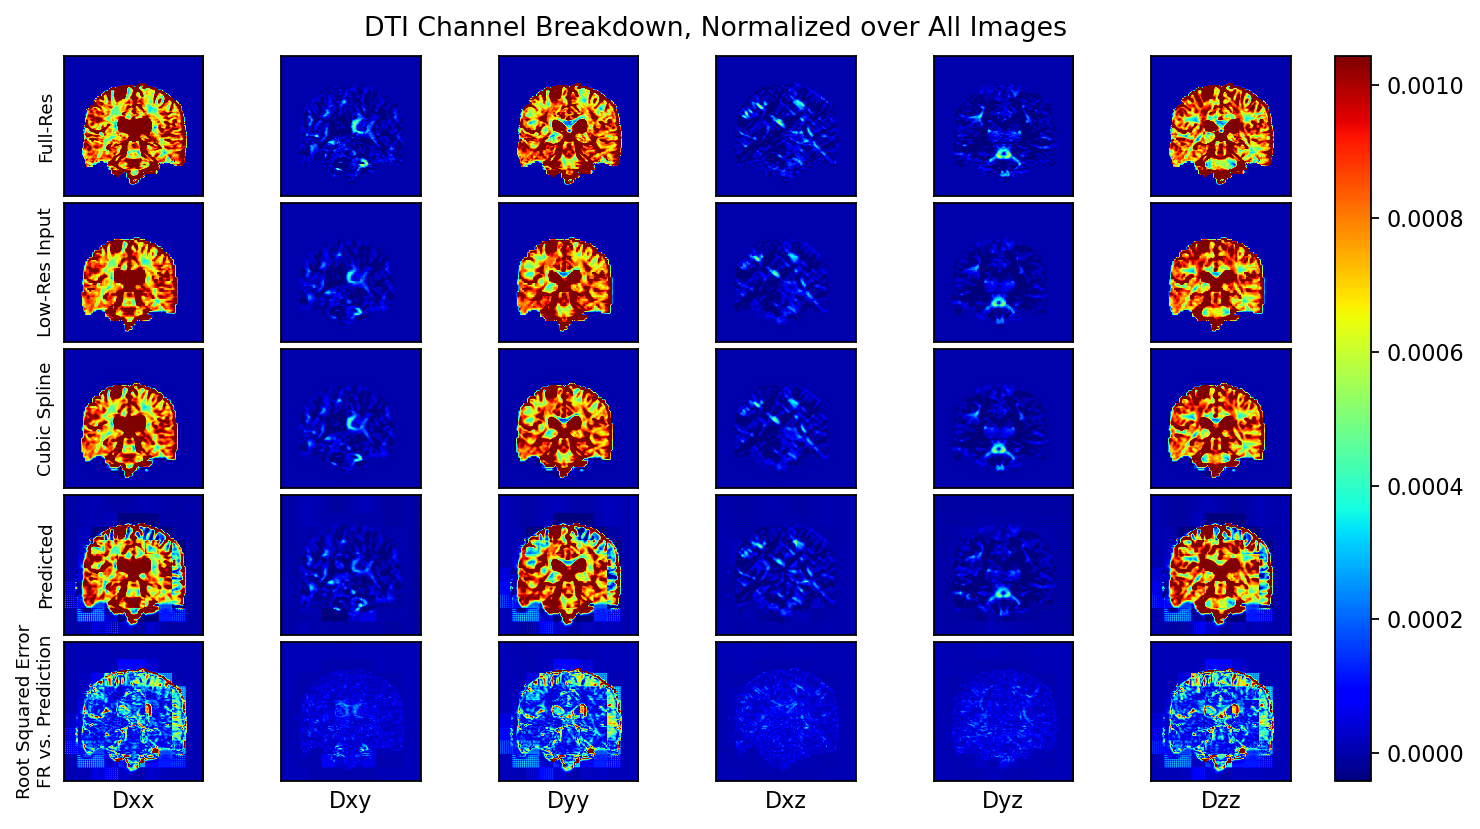

In [78]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

dti_names = [
    "Full-Res",
    "Low-Res Input",
    "Cubic Spline",
    "Predicted",
    "Root Squared Error\nFR vs. Prediction",
]
cmap = "jet"
# cmaps = ["Reds", "Greys", "Greens", "Purples", "Greys", "Blues", ]

dtis = [
    test_vol_results[vis_subj_idx]
    .full_res.data[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx]
    .low_res[(slice(None), *low_res_slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx].full_res_cubic_spline[(slice(None), *slice_idx)],
    test_vol_results[vis_subj_idx]
    .full_res_predicted[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
]

# Add root squared error
dtis.append(np.sqrt((dtis[0] - dtis[-1]) ** 2))

# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
# Reshape and concatenate the dtis in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).
max_dti = np.quantile(np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.95)
min_dti = np.quantile(np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.05)

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)
axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(dti[j_col]),
            cmap=cmap,
            interpolation=None,
            vmin=min_dti,
            vmax=max_dti,
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        axs.append(ax)

color_norm = mpl.colors.Normalize(vmin=min_dti, vmax=max_dti)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap),
    ax=axs,
    location="right",
    fraction=0.1,
    pad=0.03,
)
plt.suptitle(
    "DTI Channel Breakdown, Normalized over All Images",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
# plt.savefig(experiment_results_dir / "DTI_channel_sample_global_norm.png");

Text(0.5, 0.89, 'DTI Channel Breakdown, Channel-Wise Normalization')

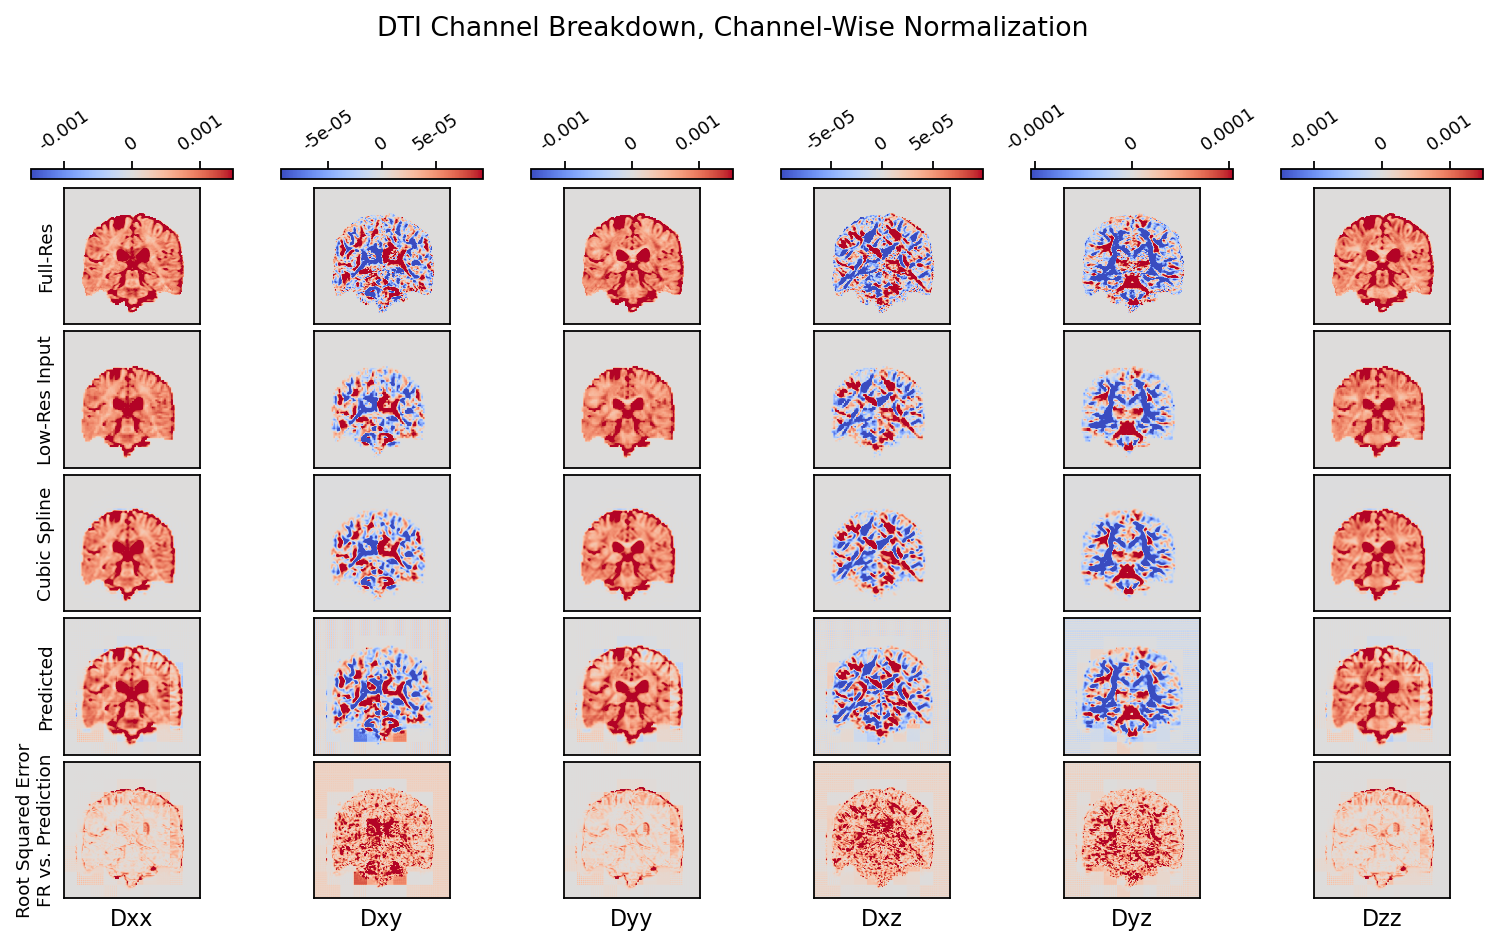

In [79]:
# Display all 6 DTIs for ground truth, predicted, low-res input, and root squared error
# Normalize by index in the DTI coefficients.
# Reshape and concatenate the dtis in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).

channel_names = ["Dxx", "Dxy", "Dyy", "Dxz", "Dyz", "Dzz"]
dti_names = [
    "Full-Res",
    "Low-Res Input",
    "Cubic Spline",
    "Predicted",
    "Root Squared Error\nFR vs. Prediction",
]
cmap = "coolwarm"
# cmaps = ["Reds", "Greys", "Greens", "Purples", "Greys", "Blues", ]

dtis = [
    test_vol_results[vis_subj_idx]
    .full_res.data[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx]
    .low_res[(slice(None), *low_res_slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx].full_res_cubic_spline[(slice(None), *slice_idx)],
    test_vol_results[vis_subj_idx]
    .full_res_predicted[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
]

# Add root squared error
dtis.append(np.sqrt((dtis[0] - dtis[-1]) ** 2))


# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
max_dtis = np.quantile(
    np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.95, axis=1
)
min_dtis = np.quantile(
    np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.05, axis=1
)

max_dtis = np.max(np.abs([max_dtis, min_dtis]), axis=0)
min_dtis = -1 * max_dtis

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 7), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]
    axs_cols = list()

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(dti[j_col]),
            cmap=cmap,
            interpolation=None,
            vmin=min_dtis[j_col],
            vmax=max_dtis[j_col],
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])

        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        axs_cols.append(ax)

    axs.append(axs_cols)

# Place colorbars on each column.
for j_col in range(ncols):

    full_col_ax = [axs[i][j_col] for i in range(nrows)]

    color_norm = mpl.colors.Normalize(vmin=min_dtis[j_col], vmax=max_dtis[j_col])

    color_mappable = mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap)
    cbar = fig.colorbar(
        color_mappable,
        ax=full_col_ax,
        location="top",
        orientation="horizontal",
        pad=0.01,
        shrink=0.85,
    )
    cbar.ax.tick_params(labelsize=8, rotation=35)
    cbar.ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:g}"))
#     cbar.ax.ticklabel_format(scilimits=(3, -3), useOffset=False)

plt.suptitle(
    "DTI Channel Breakdown, Channel-Wise Normalization",
    y=max_subplot_height + 0.01,
    verticalalignment="bottom",
)
# plt.savefig(experiment_results_dir / "DTI_channel_sample_channel_wise_norm.png");

In [ ]:
# Experiment is complete, move the results directory to its final location.
experiment_results_dir = experiment_results_dir.rename(final_experiment_results_dir)